In [16]:
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)#to display complete dataframe
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

In [60]:
#Read the 'indice de cartera vencida' file, and set the col 0 ('Fecha') be the dataframe index.
indice_df = pd.read_excel('icv_mensual.xlsx', index_col=0)

In [61]:
#Resample the ICV_cartera_total into quarterly periods, so we get the average icv of each three 
#months; this is done because the predictor variables are all in quarters frequency, so the 
#predictors and the labels must to match. 
quarterly_resampled_indice_df = indice_df.ICV_cartera_total.resample('Q').mean()

In [59]:
uwu = list(quarterly_resampled_indice_df)
uwu

[0.1063651858499708,
 0.10320377181879582,
 0.09599874982854727,
 0.09103322293249055,
 0.0866603693400196,
 0.08260861955513403,
 0.07830361961714956,
 0.07198133465138443,
 0.06724366206833211,
 0.06032316091779729,
 0.04840107173260568,
 0.03825258204065412,
 0.034839025228187,
 0.033238239807999566,
 0.032203548096397173,
 0.029711384563276932,
 0.02933555328407188,
 0.029875464738225676,
 0.027924977675987322,
 0.026986482272858714,
 0.028108400160878882,
 0.02975072068353843,
 0.03147880169103537,
 0.033405624308845396,
 0.037565518608171096,
 0.040492752050017525,
 0.04145301967525302,
 0.0423959322150227,
 0.04597119150143872,
 0.04781606640197792,
 0.04672763067681588,
 0.044998317399789566,
 0.04462114664016362,
 0.04247242839962703,
 0.03775552368427116,
 0.03210635415057273,
 0.03084756482558236,
 0.0292094903109734,
 0.028587173230432847,
 0.02742963463832924,
 0.028012914815858898,
 0.029438275540402913,
 0.02673333333333333,
 0.029266666666666663,
 0.031082425403270348,


### EXPLORATORY DATA ANALYSIS WITH PANDAS AND NUMPY

In [64]:
#read the 'variables' dataset
data = pd.read_excel('variables_macro_trimestral.xlsx', index_col=0)
#Remove the first 4 rows, to correctly match with the ICV data
variables_df = data.iloc[4:].copy()

In [65]:
#Merge the labels (ICV) and the predictors (variables) into a signel dataframe.
variables_df['icv_cartera_total'] = list(quarterly_resampled_indice_df)

In [67]:
#add an incremental column number to see how the variables change with transcurred time
variables_df['count'] = range(0, len(variables_df.index))

In [68]:
#Let's check the column datatypes 
variables_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76 entries, 2002-03-01 to 2020-12-01
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Desempleo          76 non-null     float64
 1   IPC                72 non-null     float64
 2   TRM                76 non-null     float64
 3   Exportaciones      47 non-null     float64
 4   Importaciones      48 non-null     float64
 5   PIB                63 non-null     float64
 6   icv_cartera_total  76 non-null     float64
 7   count              76 non-null     int32  
dtypes: float64(7), int32(1)
memory usage: 5.0 KB


In [69]:
#Check for null values, and how many per column
variables_df.isnull().sum()

Desempleo             0
IPC                   4
TRM                   0
Exportaciones        29
Importaciones        28
PIB                  13
icv_cartera_total     0
count                 0
dtype: int64

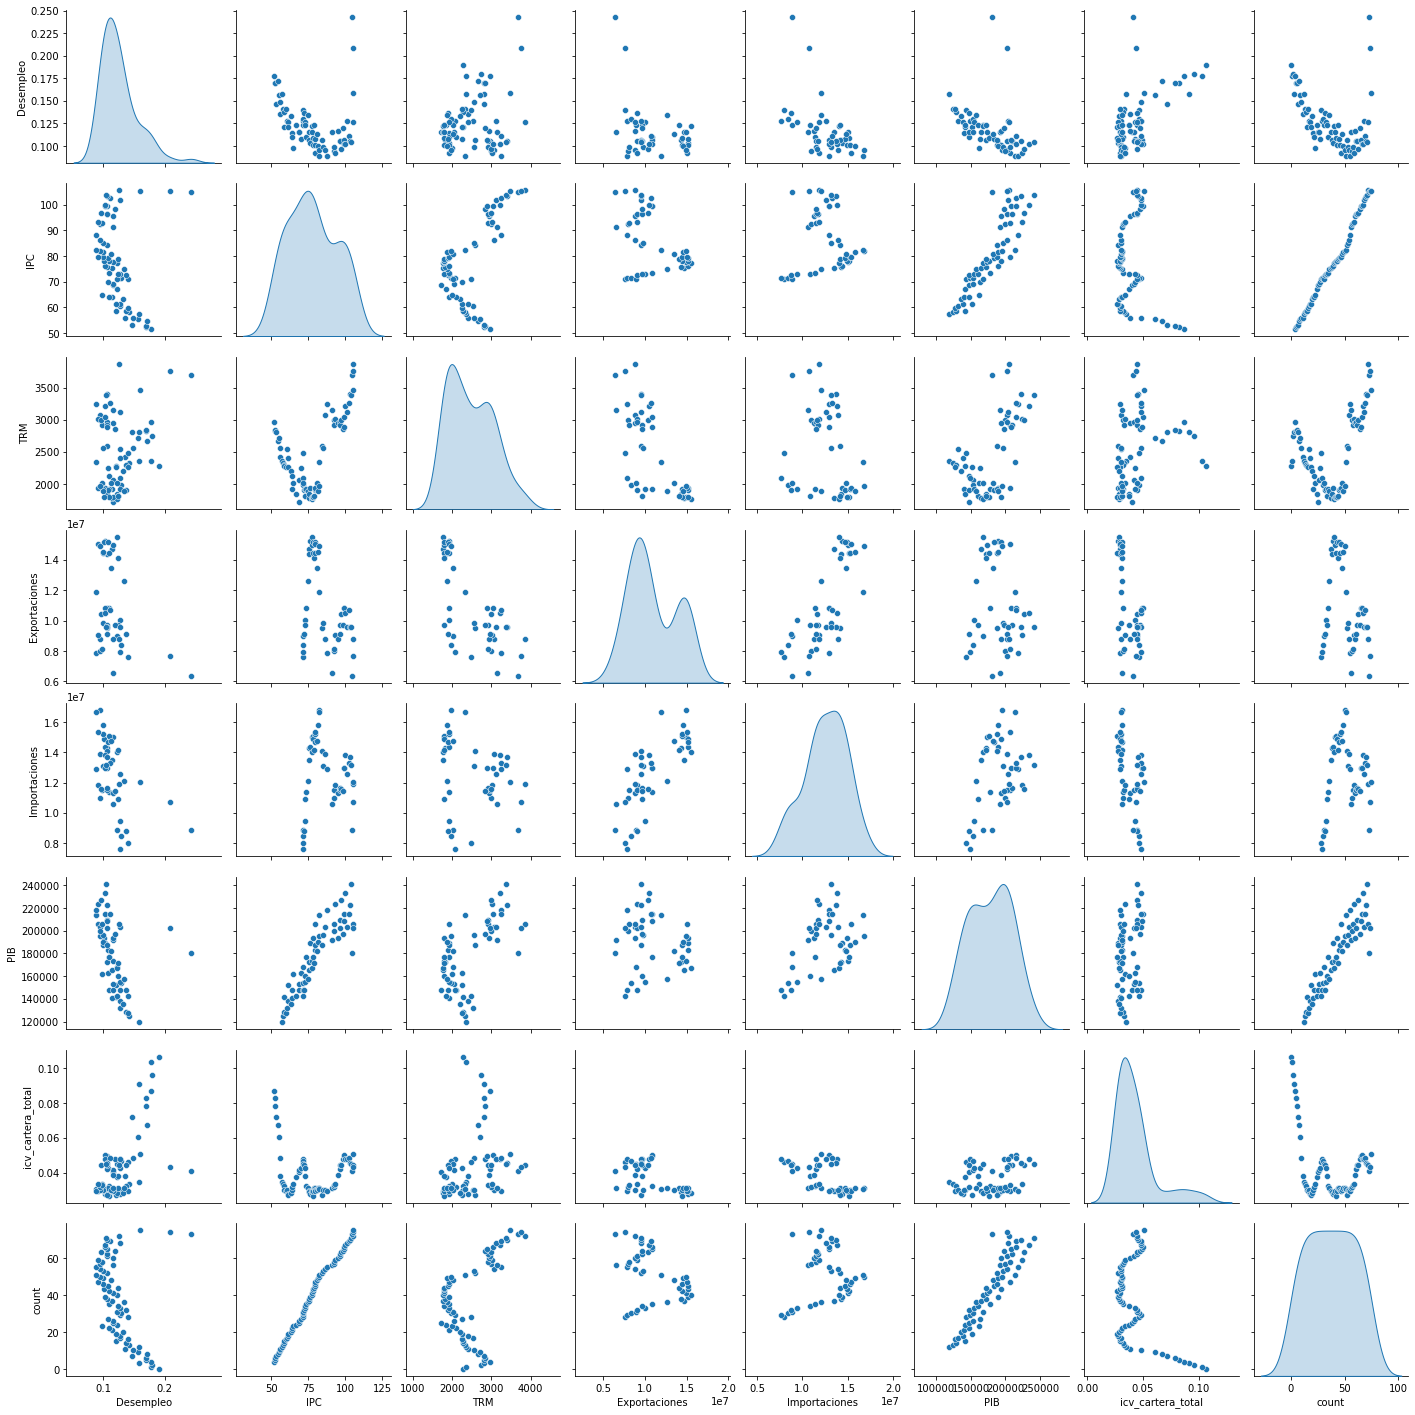

In [70]:
#Plot for correlations between variables
sns.pairplot(variables_df, diag_kind = 'kde')

### Dealing with nulls

#### Linear regression imputation

In [71]:
#This function fills the null values of the columns which has high correlation with a column
#which does not have null values

def regression_imputer(dataframe, column_name):
    #dataframe must has a column called 'count' which is only a consecutive number of rows.
    df = dataframe.copy()  

    #regression between count and 'column_name'
    #The following code generates a df with the neccesary data to train the regression model, 
    #excluding the null values.
    model_data = df[['count', f'{column_name}']][df[f'{column_name}'].notnull()]

    #create x and y arrays, we must reshape it because LinearRegression() object only accepts array 
    #like inputs
    x = model_data['count'].values.reshape(-1, 1)
    y = model_data[f'{column_name}'].values.reshape(-1, 1)

    #Create the Linear Regression model to estimate the missing data
    regression_model = linear_model.LinearRegression()
    #fit the model
    regression_model.fit(X = x, y = y)

    #generate the x values to be predicted (the 'count' values)
    x_to_predict = df['count'][df[f'{column_name}'].isnull()].values.reshape(-1,1)

    #Make the predictions
    predictions = regression_model.predict(x_to_predict)

    #We need to transform the predictions array into a numeric list.
    predictions = [float(i) for i in predictions] 

    #From the dataframe, select all the null positions in the column, and then replace them by the 
    #new predictions
    df[f'{column_name}'][df[f'{column_name}'].isnull()] = predictions
     
    return df


In [72]:
#The following list takes the column names which are going to be imputed with regression technique.
columns_to_regression_imputer = ['IPC', 'PIB']

#Create a copy of the dataframe with the null columns
imputed_df = variables_df.copy()

#apply the regression imputer to the columns that need it 
for column in columns_to_regression_imputer:

    imputed_df = regression_imputer(imputed_df, column)


c:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
